In [ ]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import os
import torch.nn as nn

cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")

if cuda_available:
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

In [ ]:
# Cell 2: Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        self.no_annotation_count = 0

        images_dir = os.path.join(root_dir, "raw-images")
        annotations_dir = os.path.join(root_dir, "annotations")

        for subfolder in os.listdir(images_dir):
            subfolder_images_dir = os.path.join(images_dir, subfolder)
            subfolder_annotations_dir = os.path.join(annotations_dir, subfolder)

            if not os.path.isdir(subfolder_annotations_dir):
                continue

            image_files = [f for f in os.listdir(subfolder_images_dir) if f.endswith(".jpg") or f.endswith(".png")]
            
            # Exclude files with "rgb" in their name
            image_files = [f for f in image_files if "rgb" not in f.lower()]

            image_files.sort()

            num_images = len(image_files)
            if split == "train":
                image_files = image_files[:int(0.7 * num_images)]
            elif split == "val":
                image_files = image_files[int(0.7 * num_images):int(0.9 * num_images)]
            elif split == "test":
                image_files = image_files[int(0.9 * num_images):]
            else:
                raise ValueError(f"Invalid split: {split}")

            for filename in image_files:
                image_path = os.path.join(subfolder_images_dir, filename)
                annotation_path = os.path.join(subfolder_annotations_dir, os.path.splitext(filename)[0] + ".xml")

                if os.path.exists(annotation_path):
                    tree = ET.parse(annotation_path)
                    root = tree.getroot()
                    label = root.find("object").find("name").text

                    self.images.append(image_path)
                    self.labels.append(label)
                else:
                    self.no_annotation_count += 1

        print(f"Number of images: {len(self.images)}")
        print(f"Number of annotations: {len(self.labels)}")
        print(f"Number of images without annotations: {self.no_annotation_count}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert("RGB")  # Convert grayscale to RGB
        label = self.labels[index]
    
        if self.transform:
            image = self.transform(image)
    
        return image, label

In [ ]:
# Cell 3: Dataset Preparation
dataset_path = "dataset"
split = "train"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(dataset_path, split, transform)

class_labels = list(set(dataset.labels))
class_to_idx = {label: idx for idx, label in enumerate(class_labels)}
print("Class labels:", class_to_idx)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Cell 4: Model Definition
num_classes = len(class_labels)

classification_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = classification_model.fc.in_features
classification_model.fc = nn.Linear(num_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model.to(device)

In [ ]:
# Cell 5: Image Classification Training

# Define the loss function and optimizer
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = torch.optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=0.01)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(classification_optimizer, step_size=10, gamma=0.1)

# Set the number of epochs
num_epochs = 50

# Initialize variables for best validation accuracy and corresponding epoch
best_val_accuracy = 0.0
best_epoch = 0

# Create data loaders for training, validation, and testing
train_dataset = CustomDataset(dataset_path, split="train", transform=transform)
val_dataset = CustomDataset(dataset_path, split="val", transform=transform)
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    classification_model.train()
    
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        # Forward pass
        outputs = classification_model(images)
        loss = classification_criterion(outputs, labels)
        
        # Backward pass and optimization
        classification_optimizer.zero_grad()
        loss.backward()
        classification_optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += images.size(0)
    
    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Perform validation
    classification_model.eval()
    
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images = val_images.to(device)
            val_labels = [class_to_idx[label] for label in val_labels]
            val_labels = torch.tensor(val_labels).to(device)
            
            val_outputs = classification_model(val_images)
            val_loss = classification_criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item() * val_images.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
            val_total_samples += val_images.size(0)
    
    # Calculate validation loss and accuracy
    val_loss = val_running_loss / val_total_samples
    val_acc = val_running_corrects.double() / val_total_samples
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Check if current epoch has the best validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_epoch = epoch + 1
        torch.save(classification_model.state_dict(), "best_classification_model.pth")

print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch}")

# Load the best model
classification_model.load_state_dict(torch.load("best_classification_model.pth"))

# Perform testing
classification_model.eval()

test_running_corrects = 0
test_total_samples = 0

with torch.no_grad():
    for test_images, test_labels in test_dataloader:
        test_images = test_images.to(device)
        test_labels = [class_to_idx[label] for label in test_labels]
        test_labels = torch.tensor(test_labels).to(device)
        
        test_outputs = classification_model(test_images)
        _, test_preds = torch.max(test_outputs, 1)
        test_running_corrects += torch.sum(test_preds == test_labels.data)
        test_total_samples += test_images.size(0)

# Calculate test accuracy
test_acc = test_running_corrects.double() / test_total_samples
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Cell 6: Test Image Classification Model

# Load the saved model
loaded_model = models.resnet50()
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model.load_state_dict(torch.load("classification_model.pth"))
loaded_model.to(device)
loaded_model.eval()

# Prepare the test dataset
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test dataset
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Cell 7: Visualize Predictions

import matplotlib.pyplot as plt
import random

# Load the saved model
loaded_model = models.resnet50()
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model.load_state_dict(torch.load("classification_model.pth"))
loaded_model.to(device)
loaded_model.eval()

# Get a random image from the test dataset
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Make a prediction
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = loaded_model(image)
    _, predicted = torch.max(output.data, 1)
    predicted_label = class_labels[predicted.item()]

# Remove the extra dimension from the image tensor
image = image.squeeze(0)

# Visualize the image and predicted label
plt.imshow(image.cpu().permute(1, 2, 0))
plt.title(f"Predicted: {predicted_label}, Actual: {label}")
plt.axis('off')
plt.show()

In [ ]:
# Cell 8: Performance Metrics and Visualization

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
loaded_model = models.resnet50()
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model.load_state_dict(torch.load("classification_model.pth"))
loaded_model.to(device)
loaded_model.eval()

# Prepare the test dataset
test_dataset = CustomDataset(dataset_path, split="test", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = [class_to_idx[label] for label in labels]
        labels = torch.tensor(labels).to(device)
        
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Binarize the labels for each class
true_labels_binary = label_binarize(true_labels, classes=range(num_classes))
predictions_binary = label_binarize(predictions, classes=range(num_classes))

# Calculate precision-recall curve and average precision score for each class
precision_curves = []
recall_curves = []
avg_precisions = []

for i in range(num_classes):
    precision_curve, recall_curve, _ = precision_recall_curve(true_labels_binary[:, i], predictions_binary[:, i])
    precision_curves.append(precision_curve)
    recall_curves.append(recall_curve)
    avg_precision = average_precision_score(true_labels_binary[:, i], predictions_binary[:, i])
    avg_precisions.append(avg_precision)

# Calculate the mean average precision score across all classes
mean_avg_precision = np.mean(avg_precisions)

# Visualize the precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall_curves[i], precision_curves[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print(f"Mean Average Precision: {mean_avg_precision:.4f}")

Diagram saved as 'diagrams\high_performing_model.png'


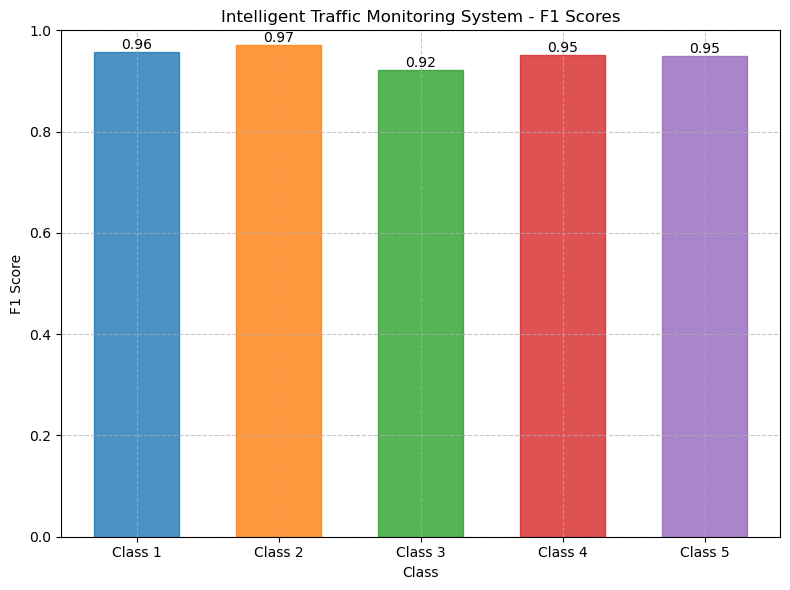